In [1]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from modAL.models import ActiveLearner, Committee

from copy import deepcopy

In [2]:
# loading the iris dataset
iris = load_iris()
# initializing Committee members
n_members = 2
learner_list = list()
performance_history_total = []
n_queries = 20

In [3]:
estimator = []
estimator.append(AdaBoostClassifier())
estimator.append(BaggingClassifier())
estimator.append(ExtraTreesClassifier())
estimator.append(GradientBoostingClassifier())
estimator.append(RandomForestClassifier())

estimator_legend = [
    'AdaBoost',
    'Bagging',
    'ExtraTrees',
    'GradientBoosting',
    'Random Forest'
]


In [4]:
    for est in estimator:
        # generate the pool
        X_pool = deepcopy(iris['data'])
        y_pool = deepcopy(iris['target'])

        for member_idx in range(n_members):
            # initial training data
            n_initial = 2
            train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
            X_train = X_pool[train_idx]
            y_train = y_pool[train_idx]

            # creating a reduced copy of the data with the known instances removed
            X_pool = np.delete(X_pool, train_idx, axis=0)
            y_pool = np.delete(y_pool, train_idx)

            # initializing learner
            learner = ActiveLearner(
                estimator=est,
                X_training=X_train, y_training=y_train
            )
            learner_list.append(learner)

        # assembling the committee
        committee = Committee(learner_list=learner_list)

        unqueried_score = committee.score(iris['data'], iris['target'])

        performance_history = [unqueried_score]

        # query by committee
        for idx in range(n_queries):
            query_idx, query_instance = committee.query(X_pool)
            committee.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )
            performance_history.append(committee.score(iris['data'], iris['target']))
            # remove queried instance from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)

        performance_history_total.append(performance_history)

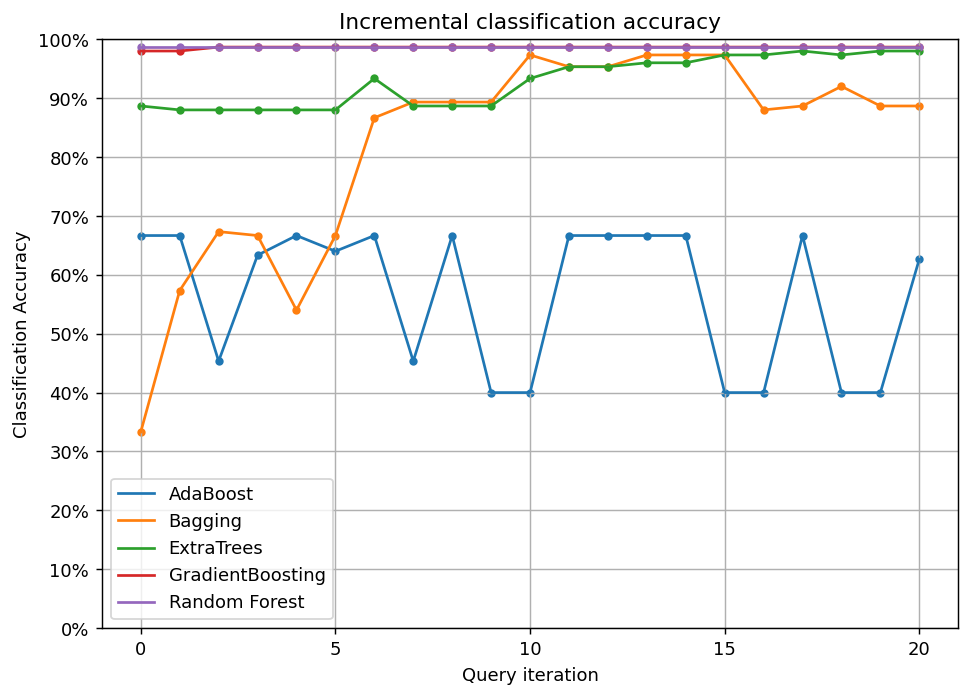

In [5]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

for idx,pht in enumerate(performance_history_total):
    ax.plot(pht)
    ax.scatter(range(len(pht)), pht, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend(estimator_legend)

plt.show()